# Application Underlying Methodology

This notebook outlines the methodologies and thought processes involved in collecting, preparing, and training machine learning models for this application. The content is organized into four main sections: data collection, initial data analysis (IDA), data preprocessing, model building, and model evaluation. Note that exploratory data analysis (EDA) is not included in this notebook to avoid redundancy with the plots and figures already present throughout the application.

## Import Library

In [1]:
# import library
from urllib.request import urlopen,Request
from bs4 import BeautifulSoup as BS
import urllib.request
import urllib.parse
import urllib.error
import ssl
import re
import json

import censusdis.data as ced
from censusdis.datasets import ACS5
from censusdis import states

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
import geopandas as gpd

import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# pd.set_option('display.max_rows', None)

## Data Collection

For this project, we will utilize data from three different sources: [Trulia](https://www.trulia.com/), [United States Census](https://www.census.gov/), and [Redfin](https://www.redfin.com/). Each source provides unique insights into the real estate market, contributing to a comprehensive and holistic view. The Trulia dataset offers detailed information about individual properties and their specifications, while the Census and Redfin datasets provide broader market insights. By combining these datasets, we can gain a deeper understanding of the real estate market, enabling data-driven decisions. Specifically, we can assess market trends, determine optimal times to buy or sell properties, and accurately evaluate property values.

### Trulia Dataset

For the Trulia dataset, we will scrape the data from its website using the BeautifulSoup package. I would like to acknowledge Karishma Parashar for her scraping code, which provided an excellent outline for the process. You can find her code on [GitHub](https://github.com/Abmun/WebScraping-RentalProperties). Her code helped me understand how web scraping works, although I had to fix some bugs and modify the code to collect the required data and the amount needed. The features we scraped from the website include:

- 'sale': the sale of the property listed on the website
- 'address': the address of the property
- 'area': neighborhood the property located
- 'bed': number of beds provided
- 'bath': number of bathrooms provided
- 'school': number of school around the area
- 'crime': crime rate of the area
- 'commute': percentage of people commute by car
- 'shop_eat': number of shops and restaurants in the area
- 'description': description of the property
- 'feature': item that property provides (heating, laundry, etc.)
- 'URL': link to the property

In [3]:
# def get_headers():
#     headers = {'accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
#             'accept-language':'en-US,en;q=0.9',
#             'cache-control':'max-age=0',
#             'upgrade-insecure-requests':'1',
#             'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.122 Safari/537.36'}
#     return headers

In [4]:
# ctx = ssl.create_default_context()
# ctx.check_hostname = False
# ctx.verify_mode = ssl.CERT_NONE

# sale = []
# address = []
# area = []
# bed = []
# bath = []
# school = []
# crime_rate = []
# commute = []
# shop_eat = []
# sugg_income = []
# descp = []
# feature = []
# addr_link = []
        

# urls = ["https://www.trulia.com/for_sale/3444_nh/1p_beds/ ",
#         "https://www.trulia.com/for_sale/3440_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/16187_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/3453_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/33656_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/3443_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/166019_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/16188_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/3438_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/3459_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/3461_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/3445_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/3450_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/3458_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/197101_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/3448_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/3449_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/3457_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/3463_nh/1p_beds/",
#         "https://www.trulia.com/for_sale/3447_nh/1p_beds/"]

In [5]:
# for x in urls:
#     count = 1
#     y = x
#     while(count < 9):  #will go till 8 pages = 240 records
#         print(x)
#         req = Request(x, headers = get_headers())  #req all headers
#         htmlfile = urlopen(req)
#         htmltext = htmlfile.read()
#         #print (htmltext)
#         soup = BS(htmltext,'html.parser')
#         #print (soup.prettify())
        
#         for tag in soup.find_all('div',attrs = {'data-testid' : 'pagination-caption'}):
#                 result = tag.get_text(strip = True) #save number of results for the search
#         try:
#             result1 = int(result.split('-')[0])
#             result2 = result.split(' ')[2]
#             result2 = int(result2.replace(',',''))
#         except:
#             pass
       
#         for tag in soup.find_all('div',attrs={'data-testid' : 'property-price'}): #sale
#                 sale_record = "NA"        
#                 sale_record = tag.get_text(strip = True)
#                 if not sale_record:
#                     sale_record = "NA"
#                 # print(sale_record)
#                 sale.append(sale_record)

#         for tag in soup.find_all('div',attrs={'data-testid' : 'property-street'}): #address
#                 address_record = "NA"
#                 address_record = tag.get_text(strip = True)
#                 if not address_record:
#                     address_record = "NA"
#                 # print(address_record)
#                 address.append(address_record)             
        
#         for tag in soup.find_all('div',attrs={'data-testid' : 'property-region'}): # area
#                 area_record = "NA"
#                 area_record = tag.get_text(strip = True)
#                 if not area_record:
#                     area_record = "NA"
#                 # print(area_record)
#                 area.append(area_record)
                
                
#         links = []                                   
#         for cards in soup.find_all('div',attrs={'class':'PropertyCard__PropertyCardContainer-sc-1ush98q-2'}):       
            
#             for link in cards.findAll('a', attrs={'href': re.compile("^/")}):\
#                 links.append("https://www.trulia.com" + link.get('href')) #appends all links in the page
       
#         #print(links) #picking up each link and reading inside it
#         for link in links:
#             addr_link.append(link)
#             req = Request(link, headers=get_headers())
#             htmlfile = urlopen(req)
#             htmltext = htmlfile.read()
#             #print (htmltext)
#             soup = BS(htmltext,'html.parser')  #reads inside links
#             #print("hello")
           
#             for tag in soup.find_all('div', attrs= {'class': 'Grid__CellBox-sc-5ig2n4-0 fxOuBE'}):
#                 bed_record = "NA"
#                 bath_record = "NA"
#                 for tag2 in tag.find_all('li', attrs= {'data-testid': 'bed'}):
#                     bed_record = tag2.get_text(strip = True)
#                     if not 'Bed' in bed_record:
#                         bed_record= "NA"
#                 bed.append(bed_record)     
                
#                 for tag2 in tag.find_all('li', attrs = {'data-testid': 'bath'}):
#                     bath_record = tag2.get_text(strip= True)
#                     if not 'Bath' in bath_record:
#                         bath_record= "NA"
#                 bath.append(bath_record)
           
#             for tag in soup.find_all('div',attrs= {'aria-label': 'Schools'}):  #school
#                 school_record = "NA"
#                 school_record = tag.get_text(strip = True)
#                 if not school_record:
#                     school_record= "NA"
#                 # print(school_record)
#                 school.append(school_record)           
            
#             for tag in soup.find_all('div',attrs= {'aria-label': 'Crime'}):  #crime
#                 crime_record = "NA"
#                 crime_record = tag.get_text(strip = True)
#                 if not crime_record:
#                     crime_record= "NA"
#                 # print(crime_record)
#                 crime_rate.append(crime_record)
               
#             for tag in soup.find_all('div',attrs= {'aria-label': 'Commute'}): #commute
#                 commute_record = "NA"
#                 commute_record = tag.get_text(strip = True)
#                 if not commute_record:
#                     commute_record= "NA"
#                 # print(commute_record)
#                 commute.append(commute_record)
                
#             for tag in soup.find_all('div', attrs= {'aria-label': 'Shop & Eat'}): #shop and eat
#                 shopeat_record = "NA"
#                 shopeat_record = tag.get_text(strip = True)
#                 if not shopeat_record:
#                     shopeat_record = "NA"
#                 # print(shopeat_record)
#                 shop_eat.append(shopeat_record)
            
#             for tag in soup.find_all('div', attrs= {'class': 'HomeDetailsRentalAffordability__IncomeInformationContainer-epkvqi-0 jalLqQ'}):
#                 income_record = "NA"
#                 for tag2 in tag.find_all('span', attrs= {'class': 'Text__TextBase-sc-1i9uasc-0 dltAqT'}): #suggested income
#                     income_record = tag2.get_text(strip = True)    
#                     if not '$' in income_record:   
#                         income_record = "NA"
#                 sugg_income.append(income_record)
             
#             for tag in soup.find_all('div',attrs= {'data-testid': 'seo-description-paragraph'}): #descp
#                 descp_record = "NA"
#                 descp_record = tag.get_text(strip = True)
#                 if not descp_record:
#                     descp_record = "NA"
#                 # print(descp_record)
#                 descp.append(descp_record)
                
#             for tag in soup.find_all('div',attrs= {'data-testid': 'features-container'}): #feature
#                 feature_record = "NA"        
#                 feature_record = tag.get_text(strip= True)
#                 if not feature_record:
#                     feature_record = "NA"
#                 # print(feature_record)
#                 feature.append(feature_record)

        
#         if result1 + 30 >= result2: #stop loop from repetting itself
#             break
#         else:
#             count = count + 1
#             page = str(count) + "_p"  #changes page
#             x = y + page

In [6]:
# data_frame = pd.DataFrame(list(zip(sale, address, area, bed, bath, school, crime_rate, commute, shop_eat, descp, feature, addr_link)), columns = ["Sale", "Address", "Area", "Bed", "Bath", "School", "Crime", "Commute", "Shop_eat", "Description", "Feature", "URL"])
# data_frame

# data_frame.Area.value_counts()

# #Save the obtained dataframe to csv
# data_frame.to_csv('housing_data_scraped.csv', index = False)

### Census Dataset

For the US Census data, we need to request the information through its API. Given the vast number of variables available, most of which are not relevant to our project, the first step is to ensure that the data is available for our target region (Boston, MA). I then carefully selected features that are insightful and beneficial for the application's objectives. As a result, we imported the following features:

- 'State': the state of where the record is located
- 'County': the county of where the record is located
- 'Tract': the tract of where the record is located
- 'Location Name': the longer name of where the record is located
- 'Total Population': the total population of where the record is located
- 'Median Household Income': the median household income of where the record is located
- 'Median Age': the median age of where the record is located
- 'Occupied': the occupation count of where the record is located
- 'Vacant': the vacancy count of where the record is located
- 'Work Commute < 10 minutes': the number of people who commute less than 10 minutes to work of where the record is located
- 'Work Commute 10-14 minutes': the number of people who commute between 10-14 minutes to work of where the record is located
- 'Work Commute 15-19 minutes': the number of people who commute between 15-19 minutes to work of where the record is located
- 'Work Commute 20-24 minutes': the number of people who commute between 20-24 minutes to work of where the record is located
- 'Work Commute 25-29 minutes': the number of people who commute between 25-29 minutes to work of where the record is located
- 'Work Commute 30-34 minutes': the amount of people who commute between 30-34 minutes to work of where the record is located
- 'Work Commute 35-44 minutes': the number of people who commute between 35-44 minutes to work of where the record is located
- 'Work Commute 45-59 minutes': the number of people who commute between 45-59 minutes to work of where the record is located
- 'Work Commute > 60 minutes': the number of people who commute more than 60 minutes to work of where the record is located
- 'Geometry': a geometry data type representing an area that is enclosed by a linear ring

In [7]:
# import censusdis.data as ced
# from censusdis.datasets import ACS5
# from censusdis import states

# def get_census_data(var_value, var_label):
#     df = ced.download(dataset = ACS5, vintage = 2022, download_variables = var_value, state = states.MA, tract = '*', with_geometry = True)
#     df = df.rename(columns={df.columns[i]: new_name for i, new_name in var_label.items()})
#     return df

# var_value  = ['NAME', 'B01001_001E', 'B19013_001E', 'B01002_001E', 'B25002_002E', 'B25002_003E', 'B08135_002E', 'B08135_003E', 'B08135_004E', 'B08135_005E', 'B08135_006E', 'B08135_007E', 'B08135_008E', 'B08135_009E', 'B08135_010E']
# var_label = {0: 'State', 
#              1: 'County', 
#              2: 'Tract', 
#              3: 'Location Name', 
#              4: 'Total Population', 
#              5: 'Median Household Income',
#              6: 'Median Age',
#              7: 'Occupied',
#              8: 'Vacant',
#              9: 'Work Commute < 10 minutes',
#              10: 'Work Commute 10-14 minutes',
#              11: 'Work Commute 15-19 minutes',
#              12: 'Work Commute 20-24 minutes',
#              13: 'Work Commute 25-29 minutes',
#              14: 'Work Commute 30-34 minutes',
#              15: 'Work Commute 35-44 minutes',
#              16: 'Work Commute 45-59 minutes',
#              17: 'Work Commute > 60 minutes',
#              18: 'Geometry'}

# census_df = get_census_data(var_value, var_label)
# census_df.to_csv('ma_census.csv', index = False)

### Redfin Dataset

The Redfin dataset is easier to obtain. We can download the CSV file directly from its [Data Center](https://www.redfin.com/news/data-center/). I downloaded four data files for the Boston region and combined them to create the Redfin dataset we will use later on. Below are the features I selected from the website:

- homes sold: the number of homes sold based on a specific time frame
- active listings: the number of active listings on Redfin's website based on a specific time frame
- median sale price: the median sale price of listings on Redfin's website based on a specific time frame
- median sale PPSF (price per square foot): the median sale PPSF of listings on Redfin's website based on a specific time frame

In [8]:
# # import dataset
# active_listing_df = pd.read_csv('active_listings.csv')
# homes_sold_df = pd.read_csv('homes_sold.csv')
# median_sale_ppsf_df = pd.read_csv('median_sale_ppsf.csv')
# median_sale_price_df = pd.read_csv('median_sale_price.csv')

In [9]:
# # merge dataset: active_listing_df, homes_sold_df, median_sale_ppsf_df, median_sale_price_df
# df_merge_1 = active_listing_df.merge(homes_sold_df, left_on = 'Period Begin', right_on = 'Period Begin')
# df_merge_2 = df_merge_1.merge(median_sale_ppsf_df, left_on = 'Period Begin', right_on = 'Period Begin')
# redfin_merged_df = df_merge_2.merge(median_sale_price_df, left_on = 'Period Begin', right_on = 'Period Begin', suffixes = ("_q", "_z"))

# redfin_merged_df.to_csv('redfin.csv', index = False)

## Import Dataset

In [10]:
# import CSV dataset
trulia_df = pd.read_csv('housing_data_scraped.csv')
census_df = pd.read_csv('ma_census.csv')
redfin_df = pd.read_csv('redfin.csv')

## Initial Data Analysis

In this section, we present an initial overview of the datasets we will be working with: the Trulia dataset, the Census dataset, and the Redfin dataset. Based on the insights gathered from this preliminary analysis, we can envision various data preprocessing steps, visualizations, and feature engineering techniques that need to be implemented.

We can see that all three datasets require significant cleaning, such as extracting values from text data and changing data types, to ensure they are ready for further analysis.

### Trulia Dataset

An important point to note about the Trulia dataset is that, aside from the "bed" and "bath" variables, there are no nan values in other variables. However, we observe missing data in columns such as "Crime" and "School," where the scraping code was unable to retrieve information for certain listings (e.g., see index 0 for "Crime" and index 3 for "School"). To address this, we will need to redefine these missing values and impute them later on.

In [11]:
trulia_df.head()

,Sale,Address,Area,Bed,Bath,School,Crime,Commute,Shop_eat,Description,Feature,URL
0,"$352,000",23 Eutaw St #2,"East Boston, Boston, MA",3 Beds,1 Bath,Schools6 Elementary Schools3 Middle Schools2 H...,Crime,Commute41% of residents commute by car.,Shop & Eat182 Restaurants39 Groceries40 Nightlife,"23 Eutaw St #2,Boston, MA is a 3 bedroom, 1 ba...","Details for 23 Eutaw St #2Multi FamilyCats, sm...",https://www.trulia.com/p/ma/boston/23-eutaw-st...
1,"$368,000",132 Bremen St,"East Boston, Boston, MA",3 Beds,1 Bath,Schools8 Elementary Schools4 Middle Schools,CrimeLow crime relative to the rest of Suffolk...,Commute41% of residents commute by car.,Shop & Eat285 Restaurants38 Groceries99 Nightlife,"132 Bremen St,Boston, MA is a 3 bedroom, 1 bat...",Details for 132 Bremen StMulti FamilyBuilt in ...,https://www.trulia.com/p/ma/boston/132-bremen-...
2,"$288,000",76 Havre St #2,"East Boston, Boston, MA",2 Beds,1 Bath,Schools5 Elementary Schools2 Middle Schools,CrimeHigh crime relative to the rest of Suffol...,Commute41% of residents commute by car.,Shop & Eat439 Restaurants61 Groceries181 Night...,"76 Havre St #2,Boston, MA is a 2 bedroom, 1 ba...",Details for 76 Havre St #2Multi FamilyNo pets ...,https://www.trulia.com/p/ma/boston/76-havre-st...
3,"$431,200",303 Maverick St #3,"East Boston, Boston, MA",4 Beds,1 Bath,School,CrimeLowest crime relative to the rest of Suff...,Commute41% of residents commute by car.,Shop & Eat345 Restaurants46 Groceries140 Night...,"303 Maverick St #3,Boston, MA is a 4 bedroom, ...",Details for 303 Maverick St #3Multi Family54 D...,https://www.trulia.com/p/ma/boston/303-maveric...
4,"$288,000",220 Saratoga St #1,"East Boston, Boston, MA",2 Beds,1 Bath,Schools6 Elementary Schools3 Middle Schools2 H...,CrimeLow crime relative to the rest of Suffolk...,Commute41% of residents commute by car.,Shop & Eat198 Restaurants34 Groceries56 Nightlife,"220 Saratoga St #1,Boston, MA is a 2 bedroom, ...",Details for 220 Saratoga St #1Multi Family58 D...,https://www.trulia.com/p/ma/boston/220-saratog...


In [12]:
trulia_df.shape

(3894, 12)

In [13]:
trulia_df.describe()

,Sale,Address,Area,Bed,Bath,School,Crime,Commute,Shop_eat,Description,Feature,URL
count,3894,3894,3894,3892,3823,3894,3894,3894,3894,3894,3894,3894
unique,419,2659,50,14,15,275,11,23,1141,3085,2994,3085
top,"$400,000",Address Not Disclosed,"Roxbury, Boston, MA",2 Beds,1 Bath,School,CrimeLowest crime relative to the rest of Suff...,Commute21% of residents commute by car.,Shop & Eat644 Restaurants65 Groceries220 Night...,"37 Telegraph St #3,Boston, MA is a 2 bedroom, ...",Home DetailsMulti FamilyNo pets allowed11 Days...,https://www.trulia.com/p/ma/boston/37-telegrap...
freq,146,408,267,1374,2887,633,1356,731,40,7,14,7


In [14]:
trulia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3894 entries, 0 to 3893
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sale         3894 non-null   object
 1   Address      3894 non-null   object
 2   Area         3894 non-null   object
 3   Bed          3892 non-null   object
 4   Bath         3823 non-null   object
 5   School       3894 non-null   object
 6   Crime        3894 non-null   object
 7   Commute      3894 non-null   object
 8   Shop_eat     3894 non-null   object
 9   Description  3894 non-null   object
 10  Feature      3894 non-null   object
 11  URL          3894 non-null   object
dtypes: object(12)
memory usage: 365.2+ KB


### Census Dataset

In [15]:
census_df.head()

,State,County,Tract,Location Name,Total Population,Median Household Income,Median Age,Occupied,Vacant,Work Commute < 10 minutes,Work Commute 10-14 minutes,Work Commute 15-19 minutes,Work Commute 20-24 minutes,Work Commute 25-29 minutes,Work Commute 30-34 minutes,Work Commute 35-44 minutes,Work Commute 45-59 minutes,Work Commute > 60 minutes,Geometry
0,25,1,10100,Census Tract 101; Barnstable County; Massachus...,3630,91447.0,56.1,1996,2909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-70.245385 42.063733, -70.238087 42...."
1,25,1,10206,Census Tract 102.06; Barnstable County; Massac...,4352,97396.0,59.1,1975,2887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-70.0772923828467 41.9578449682566, ..."
2,25,1,10208,Census Tract 102.08; Barnstable County; Massac...,1627,89243.0,65.0,1031,2418,1090.0,380.0,690.0,2140.0,NaN,NaN,NaN,NaN,6805.0,"POLYGON ((-70.1542553579408 42.0771582964788, ..."
3,25,1,10304,Census Tract 103.04; Barnstable County; Massac...,2739,68633.0,60.6,1363,1572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-70.008462 41.800786, -70.003842 41...."
4,25,1,10306,Census Tract 103.06; Barnstable County; Massac...,2985,81078.0,57.6,1361,2097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-70.009013 41.876625, -70.0064441049..."


In [16]:
census_df.shape

(1620, 19)

In [17]:
census_df.describe()

,State,County,Tract,Total Population,Median Household Income,Median Age,Occupied,Vacant,Work Commute < 10 minutes,Work Commute 10-14 minutes,Work Commute 15-19 minutes,Work Commute 20-24 minutes,Work Commute 25-29 minutes,Work Commute 30-34 minutes,Work Commute 35-44 minutes,Work Commute 45-59 minutes,Work Commute > 60 minutes
count,1620.0,1620.000000,1620.000000,1620.000000,1586.000000,1600.000000,1620.000000,1620.000000,1161.000000,1166.000000,1167.000000,1166.000000,1156.000000,1166.000000,1165.000000,1163.000000,1163.000000
mean,25.0,17.000000,436432.550000,4311.237654,104108.629887,40.692188,1691.972222,159.456173,1059.603790,2454.163808,4098.140531,5348.979417,3475.674740,8874.056604,6993.772532,10567.196905,19837.347377
std,0.0,7.702305,265119.228267,1688.223489,46027.403016,7.855668,647.860771,311.575383,694.081145,1539.506278,2317.798640,2949.388790,2082.812269,4760.526710,4123.776393,6421.442837,12711.592861
min,25.0,1.000000,101.000000,0.000000,16095.000000,19.700000,0.000000,0.000000,40.000000,160.000000,270.000000,540.000000,250.000000,600.000000,625.000000,810.000000,1080.000000
25%,25.0,9.000000,250875.000000,3175.500000,72164.750000,35.500000,1258.750000,41.000000,530.000000,1326.250000,2502.500000,3240.000000,1913.750000,5280.000000,3905.000000,5907.500000,10047.500000
50%,25.0,17.000000,383851.000000,4214.000000,98626.000000,40.700000,1671.000000,89.000000,910.000000,2132.500000,3690.000000,4830.000000,3050.000000,8010.000000,6220.000000,9270.000000,17060.000000
75%,25.0,25.000000,655325.000000,5426.000000,128493.500000,45.700000,2102.500000,156.000000,1455.000000,3193.750000,5192.500000,6883.750000,4550.000000,11396.250000,9090.000000,13995.000000,27112.500000
max,25.0,27.000000,990101.000000,11895.000000,250001.000000,77.400000,4117.000000,3671.000000,4450.000000,12725.000000,15060.000000,20520.000000,13500.000000,33180.000000,28360.000000,41600.000000,84020.000000


In [18]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620 entries, 0 to 1619
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   State                       1620 non-null   int64  
 1   County                      1620 non-null   int64  
 2   Tract                       1620 non-null   int64  
 3   Location Name               1620 non-null   object 
 4   Total Population            1620 non-null   int64  
 5   Median Household Income     1586 non-null   float64
 6   Median Age                  1600 non-null   float64
 7   Occupied                    1620 non-null   int64  
 8   Vacant                      1620 non-null   int64  
 9   Work Commute < 10 minutes   1161 non-null   float64
 10  Work Commute 10-14 minutes  1166 non-null   float64
 11  Work Commute 15-19 minutes  1167 non-null   float64
 12  Work Commute 20-24 minutes  1166 non-null   float64
 13  Work Commute 25-29 minutes  1156 

### Redfin Dataset 

In [19]:
redfin_df.head()

,Day of Year_x,Year of Period End_x,Period Begin,Period End_x,Active Listings Yoy (tooltip),Active Listings Yoy,Active Listings,Day of Year_y,Year of Period End_y,Period End_y,...,Median Sale Ppsf Yoy (tooltip),Median Sale Ppsf Yoy,Median Sale Ppsf,Day of Year_z,Last Updated,Year of Period End_z,Period End_z,Median Sale Price Year-over-Year,Median Sale Price Year-over-year,Median Sale Price
0,1,2023,12/5/2022,1/1/2023,13.51%,14%,"5,344",1,2023,1/1/2023,...,0.51%,0.005122,$354,1,10/9/2024 13:59,2023,1/1/2023,-1.76%,-0.017551,"601,750"
1,2,2022,12/6/2021,1/2/2022,-30.55%,-31%,"4,708",2,2022,1/2/2022,...,14.48%,0.144758,$352,2,10/9/2024 13:59,2022,1/2/2022,12.70%,0.126955,"612,500"
2,3,2021,12/7/2020,1/3/2021,-10.97%,-11%,"6,779",3,2021,1/3/2021,...,9.99%,0.099852,$308,3,10/9/2024 13:59,2021,1/3/2021,10.81%,0.108053,"543,500"
3,7,2024,12/11/2023,1/7/2024,-10.71%,-11%,"4,443",7,2024,1/7/2024,...,8.55%,0.085529,$384,7,10/9/2024 13:59,2024,1/7/2024,12.68%,0.126832,"671,000"
4,8,2023,12/12/2022,1/8/2023,16.26%,16%,"4,976",8,2023,1/8/2023,...,-0.08%,-0.000757,$354,8,10/9/2024 13:59,2023,1/8/2023,-2.78%,-0.027756,"595,475"


In [20]:
redfin_df.shape

(197, 27)

In [21]:
redfin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Day of Year_x                     197 non-null    int64  
 1   Year of Period End_x              197 non-null    int64  
 2   Period Begin                      197 non-null    object 
 3   Period End_x                      197 non-null    object 
 4   Active Listings Yoy (tooltip)     197 non-null    object 
 5   Active Listings Yoy               197 non-null    object 
 6   Active Listings                   197 non-null    object 
 7   Day of Year_y                     197 non-null    int64  
 8   Year of Period End_y              197 non-null    int64  
 9   Period End_y                      197 non-null    object 
 10  adjusted_average_homes_sold       197 non-null    object 
 11  adjusted_average_homes_sold_yoy   197 non-null    float64
 12  Average 

## Data Preprocessing

### Clean Trulia Dataset

In [22]:
# check for duplicate values
print("Number of duplicate rows:", sum(trulia_df.duplicated(subset=['Address'])))

Number of duplicate rows: 1235


In [23]:
# remove duplicate
trulia_df = trulia_df.drop_duplicates(subset = ['Address'])
trulia_df = trulia_df.reset_index(drop = True)
trulia_df.shape

(2659, 12)

In [24]:
# remove special characters for "Sale" variable
trulia_df.Sale = trulia_df.Sale.apply(lambda x: x.replace('$',''))
trulia_df.Sale = trulia_df.Sale.apply(lambda x: x.replace('/mo',''))
trulia_df.Sale = trulia_df.Sale.apply(lambda x: x.replace(',',''))
trulia_df.Sale = trulia_df.Sale.apply(lambda x: x.replace(' ',''))

count       2659
unique       384
top       480000
freq         102
Name: Sale, dtype: object


<Axes: xlabel='Sale'>

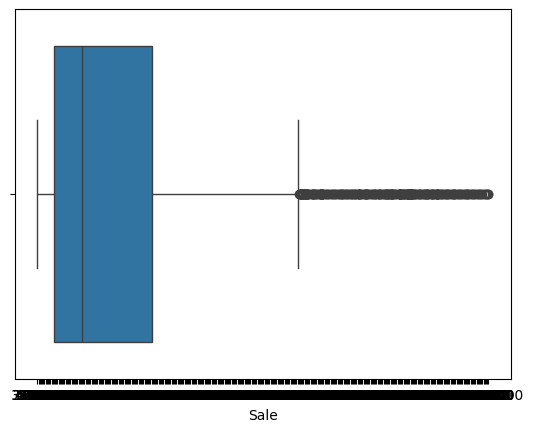

In [25]:
# view "Sale variable distribution and outlier analysis
print(trulia_df.Sale.describe())
sns.boxplot(x=trulia_df['Sale'])

As we can see from the information provided above, there are many outliers toward the upper bound of the distribution. When we observe the data closely, this trend is common in the real estate market of big cities, where more than 20% of properties are considered luxury and are valued significantly higher than the rest. Since our dataset is not large and these outliers are justified, we decided not to remove them but to take them into consideration for the rest of the analysis.

In [26]:
# apply average for those with ranges for "Sale" variable
for x in range(len(trulia_df['Sale'])):
    if '-' in trulia_df.Sale[x]:
        a = int(trulia_df.Sale[x].split('-')[0])
        b = int(trulia_df.Sale[x].split('-')[1])
        trulia_df.Sale[x] = (a+b) / 2

In [27]:
# check unique values for "Bed" variable
trulia_df.Bed.value_counts()

Bed
2 Beds           932
1 Bed            672
3 Beds           585
4 Beds           316
5 Beds            84
Studio-3 Beds     19
Studio-2 Beds     14
1-3 Beds          10
1-2 Beds           9
Studio-1 Bed       6
6 Beds             5
7 Beds             3
3-4 Beds           2
9 Beds             1
Name: count, dtype: int64

For the nan values in the "Bed" variable, I verified with the source (Trulia's website) and found that listings with nan for the "Bed" variable are either studio units or offices. Therefore, we can address this missing data by applying simple imputation, replacing nan values with 0.

In [28]:
# check missing values for "Bed" variable
trulia_df[trulia_df['Bed'].isna()].head()

,Sale,Address,Area,Bed,Bath,School,Crime,Commute,Shop_eat,Description,Feature,URL
1058,296000,189 Beacon St #GARDEN,"Back Bay, Boston, MA",NaN,1 Bath,Schools6 Elementary Schools1 Middle School5 Hi...,CrimeLowest crime relative to the rest of Suff...,Commute28% of residents commute by car.,Shop & Eat1099 Restaurants118 Groceries396 Nig...,"189 Beacon St #GARDEN,Boston, MA is a studio, ...",Details for 189 Beacon St #GARDENMulti FamilyN...,https://www.trulia.com/p/ma/boston/189-beacon-...


In [29]:
# clean text for "Bed" variable
trulia_df.Bed = trulia_df.Bed.fillna('0')

for x in range(len(trulia_df.Bed)):
    trulia_df.Bed[x] = trulia_df.Bed[x].split(' ')[0]
    if '-' in trulia_df.Bed[x]:
        trulia_df.Bed[x] = trulia_df.Bed[x].split('-')[1]

In [30]:
# check unique values for "Bath" variable
trulia_df.Bath.value_counts()

Bath
1 Bath           1931
2 Baths           428
1.5 Baths         108
2.5 Baths          41
1-2 Baths          37
3 Baths            25
3.5 Baths           7
1-3 Baths           5
1-1.5 Baths         4
4.5 Baths           2
4 Baths             2
1.5-2.5 Baths       1
1.5-2 Baths         1
1-2.5 Baths         1
1-3.5 Baths         1
Name: count, dtype: int64

Similar to the "Bed" variable, I verified with the source (Trulia's website) that listings with nan values in the "Bath" variable are offices. Therefore, we can address the missing data by applying simple imputation, replacing nan values with 0.

In [31]:
# check missing values for "Bath" variable
trulia_df[trulia_df['Bath'].isna()].head()

,Sale,Address,Area,Bed,Bath,School,Crime,Commute,Shop_eat,Description,Feature,URL
733,192000,26 School St #R3679,"Downtown, Boston, MA",1,NaN,Schools2 Elementary Schools1 Middle School,CrimeHigh crime relative to the rest of Suffol...,Commute20% of residents commute by car.,Shop & Eat991 Restaurants111 Groceries382 Nigh...,"26 School St #R3679,Boston, MA is a 1 bedroom ...",Details for 26 School St #R3679Multi FamilyRen...,https://www.trulia.com/rental/4077650890-26-Sc...
734,208000,26 School St #R3680,"Downtown, Boston, MA",1,NaN,Schools2 Elementary Schools1 Middle School,CrimeHigh crime relative to the rest of Suffol...,Commute20% of residents commute by car.,Shop & Eat991 Restaurants111 Groceries382 Nigh...,"26 School St #R3680,Boston, MA is a 1 bedroom ...",Details for 26 School St #R3680Multi FamilyRen...,https://www.trulia.com/rental/4077650892-26-Sc...
1463,192000,68 Hammond St #R2396,"South End, Boston, MA",1,NaN,Schools2 Elementary Schools6 Middle Schools5 H...,CrimeModerate crime relative to the rest of Su...,Commute23% of residents commute by car.,Shop & Eat602 Restaurants85 Groceries191 Night...,"68 Hammond St #R2396,Boston, MA is a 1 bedroom...",Details for 68 Hammond St #R2396Multi FamilyCa...,https://www.trulia.com/rental/4074040125-68-Ha...
1465,176000,41 Thorndike St #R3487,"South End, Boston, MA",1,NaN,Schools2 Elementary Schools3 Middle Schools2 H...,Crime,Commute32% of residents commute by car.,Shop & Eat498 Restaurants77 Groceries152 Night...,"41 Thorndike St #R3487,Boston, MA is a 1 bedro...",Details for 41 Thorndike St #R3487Multi Family...,https://www.trulia.com/rental/4074787661-41-Th...
1466,176000,41 Thorndike St #R3486,"South End, Boston, MA",1,NaN,Schools2 Elementary Schools3 Middle Schools2 H...,CrimeLow crime relative to the rest of Suffolk...,Commute32% of residents commute by car.,Shop & Eat498 Restaurants77 Groceries152 Night...,"41 Thorndike St #R3486,Boston, MA is a 1 bedro...",Details for 41 Thorndike St #R3486Multi Family...,https://www.trulia.com/rental/4074787659-41-Th...


In [32]:
# clean text for "Bath" variable
trulia_df.Bath = trulia_df.Bath.fillna('0')

for x in range(len(trulia_df.Bath)):
    trulia_df.Bath[x] = trulia_df.Bath[x].split(' ')[0]
    if '-' in trulia_df.Bath[x]:
        trulia_df.Bath[x] = trulia_df.Bath[x].split('-')[1]

trulia_df.head()

,Sale,Address,Area,Bed,Bath,School,Crime,Commute,Shop_eat,Description,Feature,URL
0,352000,23 Eutaw St #2,"East Boston, Boston, MA",3,1,Schools6 Elementary Schools3 Middle Schools2 H...,Crime,Commute41% of residents commute by car.,Shop & Eat182 Restaurants39 Groceries40 Nightlife,"23 Eutaw St #2,Boston, MA is a 3 bedroom, 1 ba...","Details for 23 Eutaw St #2Multi FamilyCats, sm...",https://www.trulia.com/p/ma/boston/23-eutaw-st...
1,368000,132 Bremen St,"East Boston, Boston, MA",3,1,Schools8 Elementary Schools4 Middle Schools,CrimeLow crime relative to the rest of Suffolk...,Commute41% of residents commute by car.,Shop & Eat285 Restaurants38 Groceries99 Nightlife,"132 Bremen St,Boston, MA is a 3 bedroom, 1 bat...",Details for 132 Bremen StMulti FamilyBuilt in ...,https://www.trulia.com/p/ma/boston/132-bremen-...
2,288000,76 Havre St #2,"East Boston, Boston, MA",2,1,Schools5 Elementary Schools2 Middle Schools,CrimeHigh crime relative to the rest of Suffol...,Commute41% of residents commute by car.,Shop & Eat439 Restaurants61 Groceries181 Night...,"76 Havre St #2,Boston, MA is a 2 bedroom, 1 ba...",Details for 76 Havre St #2Multi FamilyNo pets ...,https://www.trulia.com/p/ma/boston/76-havre-st...
3,431200,303 Maverick St #3,"East Boston, Boston, MA",4,1,School,CrimeLowest crime relative to the rest of Suff...,Commute41% of residents commute by car.,Shop & Eat345 Restaurants46 Groceries140 Night...,"303 Maverick St #3,Boston, MA is a 4 bedroom, ...",Details for 303 Maverick St #3Multi Family54 D...,https://www.trulia.com/p/ma/boston/303-maveric...
4,288000,220 Saratoga St #1,"East Boston, Boston, MA",2,1,Schools6 Elementary Schools3 Middle Schools2 H...,CrimeLow crime relative to the rest of Suffolk...,Commute41% of residents commute by car.,Shop & Eat198 Restaurants34 Groceries56 Nightlife,"220 Saratoga St #1,Boston, MA is a 2 bedroom, ...",Details for 220 Saratoga St #1Multi Family58 D...,https://www.trulia.com/p/ma/boston/220-saratog...


In [33]:
# clean text and create new columns for "School" variable
trulia_df.School = trulia_df.School.apply(lambda x: np.nan if x == 'School' else x)
trulia_df.School = trulia_df.School.apply(lambda x: str(x).replace('Schools','') if x != 'nan' else x)
trulia_df.School = trulia_df.School.apply(lambda x: str(x).replace('School','') if  x != 'nan' else x)

elementary_school = []
middle_school = []
high_school = []

for x in range(len(trulia_df.School)):
    elementary = 0
    middle = 0
    high = 0

    if trulia_df.School[x] == 'nan':
        elementary = np.nan
        middle = np.nan
        high = np.nan
    if 'Elementary' in trulia_df.School[x]:
        elementary = int(trulia_df.School[x].split(' ')[0])
    if 'Middle' in trulia_df.School[x]:
        if trulia_df.School[x].find('Middle') < 5:
            middle = int(trulia_df.School[x].split(' ')[0])
        else:
            middle = int(trulia_df.School[x].split(' ')[2])
    if 'High' in trulia_df.School[x]:
        if trulia_df.School[x].find('High') < 5:
            high = int(trulia_df.School[x].split(' ')[0])
        elif trulia_df.School[x].find('High') > 10 & trulia_df.School[x].find('High') < 16:
            high = int(trulia_df.School[x].split(' ')[2])
        else:
            high = int(trulia_df.School[x].split(' ')[4])
    
    elementary_school.append(elementary)
    middle_school.append(middle)
    high_school.append(high)
    
trulia_df['Elemenatary_School'] = elementary_school
trulia_df['Middle_School'] = middle_school
trulia_df['High_School'] = high_school
trulia_df['Total_School'] = trulia_df['Elemenatary_School'] + trulia_df['Middle_School'] + trulia_df['High_School']
trulia_df = trulia_df.drop(['School'], axis=1)

In [34]:
# clean text for "Crime" variable
trulia_df.Crime = trulia_df.Crime.apply(lambda x: float(np.nan) if x == 'Crime' else x)
trulia_df.Crime = trulia_df.Crime.apply(lambda x: str(x).replace('Crime','') if x != np.nan else x)
trulia_df.Crime = trulia_df.Crime.apply(lambda x: str(x).split(' ')[0] if x != np.nan else x)

In [35]:
# check unique variable for "Crime" variable
trulia_df['Crime'].value_counts()

Crime
Lowest      1001
nan          638
Low          431
Moderate     327
High         178
Highest       84
Name: count, dtype: int64

In [36]:
# apply ordinal encoding for "Crime" variable
mapping = {"Lowest": 1,
           "Low": 2,
           "Moderate": 3,
           "High": 4,
           "Highest": 5}

trulia_df["Crime"] = trulia_df["Crime"].replace(mapping)
trulia_df = trulia_df.rename(columns={"Crime": "Crime_Rate"})

In [37]:
# clean text for "Commute" variable
trulia_df.Commute = trulia_df.Commute.apply(lambda x: x.replace('Commute',''))
trulia_df.Commute = trulia_df.Commute.apply(lambda x: x.split(' ')[0])
trulia_df.Commute = trulia_df.Commute.apply(lambda x: x.replace('%',''))
trulia_df.Commute = trulia_df.Commute.apply(lambda x: x.replace("Learn",'0'))
trulia_df = trulia_df.rename(columns={'Commute': 'Car_Commute_Percentage'})

In [38]:
# clean text for "Shop_eat" variable
trulia_df.Shop_eat = trulia_df.Shop_eat.apply(lambda x: x.replace('Shop & Eat', ''))
trulia_df.Shop_eat = trulia_df.Shop_eat.apply(lambda x: x.replace('Restaurants', 'res '))
trulia_df.Shop_eat = trulia_df.Shop_eat.apply(lambda x: x.replace('Groceries', 'gro '))

restaurant = []
grocery = []
nightlife = []

for x in range(len(trulia_df.Shop_eat)):
    restaurant.append(int(trulia_df.Shop_eat[x].split(' ')[0]))
    grocery.append(int(trulia_df.Shop_eat[x].split(' ')[2]))
    if 'Nightlife' in trulia_df.Shop_eat[x]:
        nightlife.append(int(trulia_df.Shop_eat[x].split(' ')[4]))
    else:
        nightlife.append(0)
    
trulia_df['Restaurant'] = restaurant
trulia_df['Grocery'] = grocery
trulia_df['Nightlife'] = nightlife
trulia_df = trulia_df.drop(['Shop_eat'], axis=1)

In [39]:
# check unique variable for "Area" variable
trulia_df['Area'].value_counts()

Area
Allston, Boston, MA                        168
Roxbury, Boston, MA                        168
Jamaica Plain, Boston, MA                  162
East Boston, Boston, MA                    145
Fenway, Boston, MA                         141
Back Bay, Boston, MA                       139
Beacon Hill, Boston, MA                    136
North End, Boston, MA                      135
South Boston, Boston, MA                   128
Chinatown, Boston, MA                      113
South End, Boston, MA                      106
Charlestown, Charlestown, MA               103
Mission Hill, Boston, MA                    96
Charlestown, Boston, MA                     90
West Roxbury, Boston, MA                    88
Downtown, Boston, MA                        74
South Dorchester, Boston, MA                68
Mission Hill, Roxbury Crossing, MA          62
West End, Boston, MA                        59
West Roxbury, West Roxbury, MA              59
Mattapan, Boston, MA                        45
Roslinda

In [40]:
# clean text for "Area" variable
trulia_df['Area'] = trulia_df['Area'].apply(lambda x: x.split(',')[0])
trulia_df['Area'] = trulia_df['Area'].apply(lambda x: 'Dorchester' if 'Dorchester' in x else x)
trulia_df['Area'].value_counts()

Area
Charlestown      193
Allston          190
Roxbury          188
West Roxbury     180
Jamaica Plain    165
Mission Hill     161
South Boston     159
East Boston      153
Fenway           141
Back Bay         139
Beacon Hill      136
North End        135
Dorchester       134
South End        129
Chinatown        113
Roslindale        85
Downtown          74
Mattapan          69
West End          59
Hyde Park         56
Name: count, dtype: int64

I am confident that the "Area" variable plays a key role in predicting the sale price of a property, so I need to encode it to include it as one of the predictors in the models later. I chose to perform label encoding because there is an inherent order in which some neighborhoods generally have more expensive properties compared to others. To achieve this, I grouped the neighborhoods and calculated the median sale price for each. Then, I sorted the neighborhoods based on their median sale values and assigned each a number from 1 to n (where n is the total number of neighborhoods).

In [41]:
# encode "Area" variable
trulia_df["Sale"] = trulia_df["Sale"].astype(int)
avg_sale = trulia_df[['Area', 'Sale']].groupby('Area', as_index = False).median().sort_values('Sale')
avg_sale['Area_Encoded'] = [x for x in range(len(avg_sale['Area']))]
avg_sale = avg_sale[['Area', 'Area_Encoded']]

trulia_df['Area_Encoded'] = trulia_df['Area'].apply(lambda x: int(avg_sale['Area_Encoded'][avg_sale['Area'] == x]))

In [42]:
# remove "Feature" variable
trulia_df = trulia_df.drop(['Feature'], axis=1)

In [43]:
# change data type for columns in Trulia dataset
trulia_df["Bed"] = trulia_df["Bed"].astype(float)
trulia_df["Bath"] = trulia_df["Bath"].astype(float)
trulia_df["Car_Commute_Percentage"] = trulia_df["Car_Commute_Percentage"].astype(int)

trulia_cleanned = trulia_df.drop(['Description', 'URL', 'Address'], axis=1)

trulia_cleanned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2659 entries, 0 to 2658
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sale                    2659 non-null   int32  
 1   Area                    2659 non-null   object 
 2   Bed                     2659 non-null   float64
 3   Bath                    2659 non-null   float64
 4   Crime_Rate              2659 non-null   object 
 5   Car_Commute_Percentage  2659 non-null   int32  
 6   Elemenatary_School      2236 non-null   float64
 7   Middle_School           2236 non-null   float64
 8   High_School             2236 non-null   float64
 9   Total_School            2236 non-null   float64
 10  Restaurant              2659 non-null   int64  
 11  Grocery                 2659 non-null   int64  
 12  Nightlife               2659 non-null   int64  
 13  Area_Encoded            2659 non-null   int64  
dtypes: float64(6), int32(2), int64(4), objec

In [44]:
trulia_cleanned.head()

,Sale,Area,Bed,Bath,Crime_Rate,Car_Commute_Percentage,Elemenatary_School,Middle_School,High_School,Total_School,Restaurant,Grocery,Nightlife,Area_Encoded
0,352000,East Boston,3.0,1.0,nan,41,6.0,3.0,3.0,12.0,182,39,40,7
1,368000,East Boston,3.0,1.0,2,41,8.0,4.0,0.0,12.0,285,38,99,7
2,288000,East Boston,2.0,1.0,4,41,5.0,2.0,0.0,7.0,439,61,181,7
3,431200,East Boston,4.0,1.0,1,41,NaN,NaN,NaN,NaN,345,46,140,7
4,288000,East Boston,2.0,1.0,2,41,6.0,3.0,3.0,12.0,198,34,56,7


### Clean Census Dataset

In [45]:
# filter Boston's tract and separate by neighborhood
bos_tract = {
    'Brighton': [102, 201, 202, 301, 302, 401, 402, 502, 503, 505, 506, 601, 603, 701],
    'Allston': [101, 604, 703, 704, 804, 805, 806, 807],
    'Charlestown': [40100, 40200, 40300, 40401, 40600, 40801],
    'East Boston': [50101, 50200, 50300, 50400, 50500, 50600, 50700, 50901, 51000, 51101, 51200, 981300, 981600],
    'North End': [30100, 30200, 30400, 30500],
    'West End': [20301, 20305, 20304],
    'Downtown': [30302, 30301, 70102, 70104],
    'Beacon Hill': [20101, 20200, 20302, 981700],
    'Chinatown': [70202, 70103],
    'Bay Village': [70201],
    'Back Bay': [10802, 10801, 10702, 10701, 10600,10500],
    'South End': [70302,70301, 70402, 70700, 70802, 70600, 70501, 71201, 70502, 70902, 71101],
    'Fenway': [10103, 10104, 10204, 10206, 10205, 10408, 10403, 10404, 10405],
    'South Boston Waterfront': [61204, 60604, 60603, 60602, 981202],
    'South Boston': [61202, 61203, 60601, 60501, 60101, 981201, 60700, 60800, 61201, 61000, 60400, 60301, 60200, 60101, 61101],
    'Longwood': [10300],
    'Mission Hill': [81001, 81102, 80900, 80801],
    'Jamaica Plain': [81101, 120700, 81200, 981800, 120600, 120500, 81301, 120400, 120301, 120103, 120201, 120104, 120105, 110105, 981000, 110106],
    'Roxbury': [70801, 70901, 80500, 80601, 80401, 80100, 80300, 81400, 90600, 81700, 81500, 81800, 90400, 81302, 81900, 82000, 82100, 980300],
    'Dorchester': [90700, 90901, 91300, 91200, 91100, 91001, 91400, 91500, 91600, 90300, 91800, 91700, 90200, 90100, 91900, 92000, 92400, 92300, 92200, 92101, 100603, 100601, 100100, 100200, 100300, 100400, 100500, 100800, 100700],
    'West Roxbury': [980900, 981900, 130101, 130200, 110601, 130300, 130402, 130404, 130406],
    'Roslindale': [110607, 110501, 110104, 110401, 110301, 110201, 110502, 110403, 140106],
    'Mattapan': [981100, 101101, 101102, 101001, 101002, 100900],
    'Hyde Park': [980700, 140105, 140400, 140107, 140300, 140202, 140102, 140201]
}

census_filtered = pd.DataFrame()

for key in bos_tract:
    df_sub = census_df[census_df['Tract'].isin(bos_tract[key])]
    df_sub['Geometry'] = df_sub['Geometry'].apply(lambda x: Polygon([tuple(map(float, coord.split())) for coord in x.replace('POLYGON ((', '').replace('))', '').split(', ')]))

    df_mean = df_sub[['State', 'Median Household Income', 'Median Age']].groupby(['State']).mean()
    df_sum = df_sub[['State', 'Total Population', 'Occupied', 'Vacant', 'Work Commute < 10 minutes', 'Work Commute 10-14 minutes', 'Work Commute 15-19 minutes', 'Work Commute 20-24 minutes', 'Work Commute 25-29 minutes', 'Work Commute 30-34 minutes', 'Work Commute 35-44 minutes', 'Work Commute 45-59 minutes', 'Work Commute > 60 minutes']].groupby(['State']).sum()
    
    df_sum['Geometry'] = unary_union(df_sub['Geometry'])
    df_sum['Area'] = [str(key)]
    
    df = pd.concat([df_mean, df_sum], axis=1)
    
    census_filtered = pd.concat([census_filtered, df], ignore_index = True)

In [46]:
# aggreagate work commute columns
census_filtered['Work Commute Short'] = census_filtered['Work Commute < 10 minutes'] + census_filtered['Work Commute 10-14 minutes']
census_filtered['Work Commute Average'] = census_filtered['Work Commute 15-19 minutes'] + census_filtered['Work Commute 20-24 minutes'] + census_filtered['Work Commute 25-29 minutes'] + census_filtered['Work Commute 30-34 minutes'] + census_filtered['Work Commute 35-44 minutes']
census_filtered['Work Commute Long'] = census_filtered['Work Commute 45-59 minutes'] + census_filtered['Work Commute > 60 minutes']

census_filtered = census_filtered.drop(['Work Commute < 10 minutes', 
                                        'Work Commute 10-14 minutes',
                                        'Work Commute 15-19 minutes', 
                                        'Work Commute 20-24 minutes',
                                        'Work Commute 25-29 minutes', 
                                        'Work Commute 30-34 minutes',
                                        'Work Commute 35-44 minutes', 
                                        'Work Commute 45-59 minutes',
                                        'Work Commute > 60 minutes'], axis=1)

In [47]:
# round decimal features
census_cleanned = census_filtered.round({'Median Household Income': 2, 'Median Age': 1})

In [48]:
census_cleanned.head()

,Median Household Income,Median Age,Total Population,Occupied,Vacant,Geometry,Area,Work Commute Short,Work Commute Average,Work Commute Long
0,87832.79,29.9,48999,21531,1451,"POLYGON ((-71.174265 42.349584, -71.174798 42....",Brighton,24405.0,350790.0,368125.0
1,79622.00,26.8,21762,8198,944,"POLYGON ((-71.114119 42.35239, -71.110732 42.3...",Allston,6945.0,124315.0,122555.0
2,116870.30,42.6,36194,16111,1751,"MULTIPOLYGON (((-71.059795 42.368767, -71.0629...",Charlestown,16765.0,210000.0,141285.0
3,100708.83,34.8,45357,17308,1524,"POLYGON ((-71.029638 42.363352, -71.037999 42....",East Boston,13605.0,277870.0,227790.0
4,110063.50,31.0,9856,5783,973,"POLYGON ((-71.051066 42.363703, -71.051 42.362...",North End,11715.0,88195.0,37775.0


In [49]:
census_cleanned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Median Household Income  24 non-null     float64
 1   Median Age               24 non-null     float64
 2   Total Population         24 non-null     int64  
 3   Occupied                 24 non-null     int64  
 4   Vacant                   24 non-null     int64  
 5   Geometry                 24 non-null     object 
 6   Area                     24 non-null     object 
 7   Work Commute Short       24 non-null     float64
 8   Work Commute Average     24 non-null     float64
 9   Work Commute Long        24 non-null     float64
dtypes: float64(5), int64(3), object(2)
memory usage: 2.0+ KB


### Clean Redfin Dataset

In [50]:
# filter dataset and rename coulmns
redfin_filtered_df = redfin_df.filter(items=['Day of Year_x', 
                                             'Year of Period End_x', 
                                             'Period Begin', 
                                             'Period End_x', 
                                             'Active Listings Yoy (tooltip)', 
                                             'Active Listings', 
                                             'adjusted_average_homes_sold', 
                                             'adjusted_average_homes_sold_yoy', 
                                             'Median Sale Ppsf (tooltip)', 
                                             'Median Sale Ppsf Yoy',
                                             'Median Sale Price Year-over-year',
                                             'Median Sale Price'])

redfin_filtered_df.columns

Index(['Day of Year_x', 'Year of Period End_x', 'Period Begin', 'Period End_x',
       'Active Listings Yoy (tooltip)', 'Active Listings',
       'adjusted_average_homes_sold', 'adjusted_average_homes_sold_yoy',
       'Median Sale Ppsf (tooltip)', 'Median Sale Ppsf Yoy',
       'Median Sale Price Year-over-year', 'Median Sale Price'],
      dtype='object')

In [51]:
# rename columns' names
redfin_cleanned = redfin_filtered_df.rename(columns={'Day of Year_x': 'Day_of_Year', 
                                                     'Year of Period End_x': 'Year_of_Period_End',
                                                     'Period Begin': 'Period_Begin', 
                                                     'Period End_x': 'Period_End', 
                                                     'Active Listings': 'Active_Listings', 
                                                     'Active Listings Yoy (tooltip)': 'Active_Listings_YOY', 
                                                     'adjusted_average_homes_sold': 'Adjusted_Average_Homes_Sold', 
                                                     'adjusted_average_homes_sold_yoy': 'Adjusted_Average_Homes_Sold_YOY',
                                                     'Median Sale Ppsf (tooltip)': 'Median_Sale_ppsf', 
                                                     'Median Sale Ppsf Yoy': 'Median_Sale_ppsf_YOY',
                                                     'Median Sale Price Year-over-year': 'Median_Sale_Price_YOY', 
                                                     'Median Sale Price': "Median_Sale_Price"})

In [52]:
# clean "Active_Listings_YOY" variable
redfin_cleanned["Active_Listings_YOY"] = redfin_cleanned["Active_Listings_YOY"].apply(lambda x: float(x.replace('%','')) / 100)

In [53]:
# clean "Active_Listings" variable
redfin_cleanned["Active_Listings"] = redfin_cleanned["Active_Listings"].apply(lambda x: x.replace(',',''))

In [54]:
# clean "Adjusted_Average_Homes_Sold" variable
redfin_cleanned["Adjusted_Average_Homes_Sold"] = redfin_cleanned["Adjusted_Average_Homes_Sold"].apply(lambda x: x.replace(',',''))

In [55]:
# clean "Median_Sale_ppsf" variable
redfin_cleanned["Median_Sale_ppsf"] = redfin_cleanned["Median_Sale_ppsf"].apply(lambda x: x.replace('$',''))

In [56]:
# clean "Median_Sale_Price" variable
redfin_cleanned["Median_Sale_Price"] = redfin_cleanned["Median_Sale_Price"].apply(lambda x: x.replace(',',''))

In [57]:
# change data type for varaible in Redfin dataset
redfin_cleanned["Active_Listings"] = redfin_cleanned["Active_Listings"].astype(int)
redfin_cleanned["Adjusted_Average_Homes_Sold"] = redfin_cleanned["Adjusted_Average_Homes_Sold"].astype(float)
redfin_cleanned["Median_Sale_ppsf"] = redfin_cleanned["Median_Sale_ppsf"].astype(float)
redfin_cleanned["Median_Sale_Price"] = redfin_cleanned["Median_Sale_Price"].astype(float)

redfin_cleanned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Day_of_Year                      197 non-null    int64  
 1   Year_of_Period_End               197 non-null    int64  
 2   Period_Begin                     197 non-null    object 
 3   Period_End                       197 non-null    object 
 4   Active_Listings_YOY              197 non-null    float64
 5   Active_Listings                  197 non-null    int32  
 6   Adjusted_Average_Homes_Sold      197 non-null    float64
 7   Adjusted_Average_Homes_Sold_YOY  197 non-null    float64
 8   Median_Sale_ppsf                 197 non-null    float64
 9   Median_Sale_ppsf_YOY             197 non-null    float64
 10  Median_Sale_Price_YOY            197 non-null    float64
 11  Median_Sale_Price                197 non-null    float64
dtypes: float64(7), int32(1

In [58]:
redfin_cleanned.head()

,Day_of_Year,Year_of_Period_End,Period_Begin,Period_End,Active_Listings_YOY,Active_Listings,Adjusted_Average_Homes_Sold,Adjusted_Average_Homes_Sold_YOY,Median_Sale_ppsf,Median_Sale_ppsf_YOY,Median_Sale_Price_YOY,Median_Sale_Price
0,1,2023,12/5/2022,1/1/2023,0.1351,5344,725.0,-0.304890,353.96,0.005122,-0.017551,601750.0
1,2,2022,12/6/2021,1/2/2022,-0.3055,4708,1043.0,-0.019737,352.15,0.144758,0.126955,612500.0
2,3,2021,12/7/2020,1/3/2021,-0.1097,6779,1064.0,0.173098,307.62,0.099852,0.108053,543500.0
3,7,2024,12/11/2023,1/7/2024,-0.1071,4443,561.0,-0.143511,384.34,0.085529,0.126832,671000.0
4,8,2023,12/12/2022,1/8/2023,0.1626,4976,655.0,-0.299465,354.06,-0.000757,-0.027756,595475.0


### Merge Features

In [59]:
# trulia dataset and census dataset
census_sub = census_cleanned.drop("Geometry", axis = 1)
merged_df = pd.merge(trulia_cleanned, census_sub, 'left', on = 'Area')

col_list = [x for x in census_sub.columns if x is not 'Area']
for i, col in enumerate(col_list):
    merged_df = merged_df.rename(columns={col: str(col) + " by Area"})

In [60]:
# redfun dataset and merged dataset
Redfin_Median_Sale_Price = redfin_cleanned.iloc[-1, -1]
merged_df['Compare Median Sale Price'] = merged_df['Sale'].apply(lambda x: 1 if x > Redfin_Median_Sale_Price else 0)

merged_df.head()

,Sale,Area,Bed,Bath,Crime_Rate,Car_Commute_Percentage,Elemenatary_School,Middle_School,High_School,Total_School,...,Area_Encoded,Median Household Income by Area,Median Age by Area,Total Population by Area,Occupied by Area,Vacant by Area,Work Commute Short by Area,Work Commute Average by Area,Work Commute Long by Area,Compare Median Sale Price
0,352000,East Boston,3.0,1.0,nan,41,6.0,3.0,3.0,12.0,...,7,100708.83,34.8,45357,17308,1524,13605.0,277870.0,227790.0,0
1,368000,East Boston,3.0,1.0,2,41,8.0,4.0,0.0,12.0,...,7,100708.83,34.8,45357,17308,1524,13605.0,277870.0,227790.0,0
2,288000,East Boston,2.0,1.0,4,41,5.0,2.0,0.0,7.0,...,7,100708.83,34.8,45357,17308,1524,13605.0,277870.0,227790.0,0
3,431200,East Boston,4.0,1.0,1,41,NaN,NaN,NaN,NaN,...,7,100708.83,34.8,45357,17308,1524,13605.0,277870.0,227790.0,0
4,288000,East Boston,2.0,1.0,2,41,6.0,3.0,3.0,12.0,...,7,100708.83,34.8,45357,17308,1524,13605.0,277870.0,227790.0,0


### Impute Missing Values

In this section, we aim to determine the type of missingness present in the "Crime_Rate" and "School" variables. To achieve this, we will perform a logistic regression analysis with the missing value indicator as the target variable and other variables as predictors. By examining the relationships between the target variable and the predictors, we can identify whether the missingness is related to observed variables, indicating that the data is missing at random (MAR).

In [61]:
# determine data missing type for "Crime_Rate"
Crime_Rate_boo = [0 if x == 'nan' else 1 for x in merged_df['Crime_Rate']]
model = sm.Logit(Crime_Rate_boo, merged_df[['Area_Encoded', 'Sale', 'Bed', 'Bath', 'Car_Commute_Percentage']]).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.553362
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2659
Model:                          Logit   Df Residuals:                     2654
Method:                           MLE   Df Model:                            4
Date:                Mon, 09 Dec 2024   Pseudo R-squ.:               -0.004267
Time:                        10:50:15   Log-Likelihood:                -1471.4
converged:                       True   LL-Null:                       -1465.1
Covariance Type:            nonrobust   LLR p-value:                     1.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Area_Encoded               0.0395      0.009      4.568      0.000       0.023       0.056
Sale                    2.465e-07   3.15e-07      0.782      0.434   -3.71e-07    8.64e-07
Bed                        0.0233      0.047      0.492      0.622      -0.069       0.116
Bath                       0.0639      0.121      0.529      0.597      -0.173       0.301
Car_Commute_Percentage     0.0126      0.002      6.274      0.000       0.009       0.017
==========================================================================================
"""

In [62]:
# determine data missing type for "School"
Total_School_boo = [0 if x >= 0 else 1 for x in merged_df['Total_School']]
model = sm.Logit(Total_School_boo, merged_df[['Area_Encoded', 'Sale', 'Bed', 'Bath', 'Car_Commute_Percentage']]).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.442603
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2659
Model:                          Logit   Df Residuals:                     2654
Method:                           MLE   Df Model:                            4
Date:                Mon, 09 Dec 2024   Pseudo R-squ.:                -0.01017
Time:                        10:50:15   Log-Likelihood:                -1176.9
converged:                       True   LL-Null:                       -1165.0
Covariance Type:            nonrobust   LLR p-value:                     1.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Area_Encoded              -0.0506      0.011     -4.747      0.000      -0.071      -0.030
Sale                   -9.289e-07   4.58e-07     -2.029      0.042   -1.83e-06   -3.14e-08
Bed                       -0.1485      0.060     -2.490      0.013      -0.265      -0.032
Bath                       0.1067      0.146      0.733      0.464      -0.179       0.392
Car_Commute_Percentage    -0.0128      0.002     -5.524      0.000      -0.017      -0.008
==========================================================================================
"""

We observed that both the "Crime_Rate" and "School" variables have significant predictors, namely "Area_Encoded" and "Car_Commute_Percentage," with p-values equal to 0. This suggests that the missingness in these variables is of the Missing at Random (MAR) type. Therefore, we can use K-Nearest Neighbors (KNN) imputation to fill in the missing values for these features.

KNN imputation is a suitable choice for MAR missingness because it utilizes the relationships between existing data points to estimate missing values. This method is effective at capturing the underlying patterns within the data, even when the missingness depends on observed variables.

In [63]:
merged_df_num = merged_df.drop('Area', axis = 1)

imputer = IterativeImputer(max_iter=10, initial_strategy = 'median', random_state = 1)
final_df = pd.DataFrame(imputer.fit_transform(merged_df_num), columns = merged_df_num.columns)

final_df['Area'] = merged_df['Area']

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2659 entries, 0 to 2658
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Sale                             2659 non-null   float64
 1   Bed                              2659 non-null   float64
 2   Bath                             2659 non-null   float64
 3   Crime_Rate                       2659 non-null   float64
 4   Car_Commute_Percentage           2659 non-null   float64
 5   Elemenatary_School               2659 non-null   float64
 6   Middle_School                    2659 non-null   float64
 7   High_School                      2659 non-null   float64
 8   Total_School                     2659 non-null   float64
 9   Restaurant                       2659 non-null   float64
 10  Grocery                          2659 non-null   float64
 11  Nightlife                        2659 non-null   float64
 12  Area_Encoded        

### Export Clean Dataset

In [64]:
# final_df.to_csv('final_df.csv', index = False)
# census_cleanned.to_csv('census_df.csv', index = False)
# redfin_cleanned.to_csv('redfin_df.csv', index = False)

## Feature Selection

I will utilize correlation analysis for feature selection, focusing on identifying the top eight features that show the strongest correlation with the target variable, "Sale." This approach will help in isolating the most influential predictors, thereby enhancing the model's accuracy and performance.

Text(0.5, 1.0, 'Correlation Heatmap')

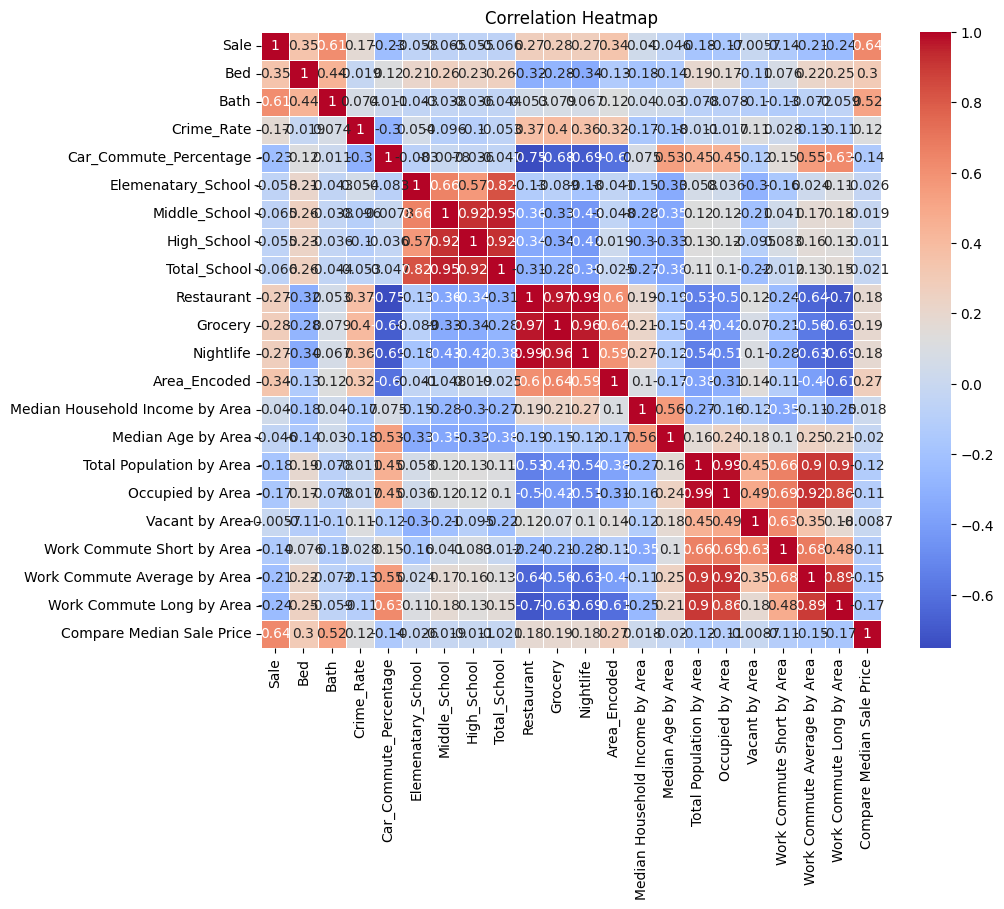

In [65]:
corr_matrix = final_df.drop('Area', axis = 1).corr()

plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5) 
plt.title('Correlation Heatmap')

In [66]:
correlations = corr_matrix['Sale'].drop('Sale')
top_8_features = correlations.abs().sort_values(ascending=False).head(8)

print(top_8_features)

Compare Median Sale Price    0.636860
Bath                         0.613119
Bed                          0.345183
Area_Encoded                 0.337997
Grocery                      0.277510
Nightlife                    0.274149
Restaurant                   0.269739
Work Commute Long by Area    0.239123
Name: Sale, dtype: float64


Initially, I planned to select the top eight features, but after observing the weak correlation of the last four features, I decided to use only the top four features as predictors for the "Sale" target variable.

## Model Building & Evaluation

The four model I will be using for this task are Linear Regression, Lasso Regression, XGBoost Regressor, and Gradien Boosting Regressor. 

Linear regression is a good model for predicting housing prices because it allows for a simple and easy  way to identify the relationship between key features of a property. Specifically, it's coefficients provide clear insights into how each feature affects the price, allow us to understand which predictors are significant.

Lasso regression is effective at handling the large number of potential features often involved in real estate data. But for our dataset, we won't be able to utelize its unique features. It also helps with preventing overfitting, ensuring that the model generalizes well to new/test data.

XGBoost Regressor is very effective for our project because of its ability to handle complex datasets with high accuracy and speed. The model builds an ensemble of decision trees in a sequential manner, optimizing each subsequent tree to correct the errors of the previous ones. Its iterative process helps the model captures intricate patterns and interactions in the data. XGBoost regressor is also great at preventing overfitting.

Gradient Boosting Regressor is also very effective because of its ability to combine the strengths of multiple weak learners. Similar to XGBoost, it iteratively builds an ensemble of decision trees, where each tree corrects the errors of the previous ones. 

I acknowledge that with the limited number of selected features, we won't be able to fully utilize the capabilities of these models. However, it will still be valuable to train them with our data and assess their effectiveness.

Additionally, I will tune the best-performing model and compare its results with the other models. We will use Mean Squared Error (MSE) and $R^2$ as our evaluation metrics. The $R^2$ value measures how well a regression model fits the data, indicating the proportion of variation in the target variable explained by the predictor variables. A higher $R^2$ value signifies a better fit. MSE calculates the average of the squared differences between predicted and actual values, with a lower MSE indicating better model performance.

In [67]:
# train and test split
X = final_df[['Compare Median Sale Price', 'Area_Encoded', 'Bed', 'Bath']]
y = final_df['Sale']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [68]:
# scale data
std_slc = StandardScaler()
std_slc.fit(X_train)

X_train_std = std_slc.transform(X_train)
X_test_std = std_slc.transform(X_test)

### Linear Regression

In [69]:
linear = LinearRegression()
linear.fit(X_train_std, y_train)

LinearRegression()

In [70]:
y_pred = linear.predict(X_test_std)

mse = mean_squared_error(y_test, y_pred) 
print(f'Mean Squared Error (MSE): {mse}') 
r2 = r2_score(y_test, y_pred) 
print(f'R-squared (R²): {r2}')

Mean Squared Error (MSE): 14503267297.250822
R-squared (R²): 0.6495485849170595


### Lasso regression

In [71]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_std, y_train)

Lasso(alpha=0.1)

In [72]:
y_pred = lasso.predict(X_test_std)

mse = mean_squared_error(y_test, y_pred) 
print(f'Mean Squared Error (MSE): {mse}') 
r2 = r2_score(y_test, y_pred) 
print(f'R-squared (R²): {r2}')

Mean Squared Error (MSE): 14503266466.115047
R-squared (R²): 0.649548605000307


### XGBoost Regressor

In [73]:
xgboost = xgb.XGBRegressor(random_state = 1)
xgboost.fit(X_train_std, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In [74]:
y_pred = xgboost.predict(X_test_std)

mse = mean_squared_error(y_test, y_pred) 
print(f'Mean Squared Error (MSE): {mse}') 
r2 = r2_score(y_test, y_pred) 
print(f'R-squared (R²): {r2}')

Mean Squared Error (MSE): 7330266159.133716
R-squared (R²): 0.8228742464885859


### Gradient Boosting Regressor

In [75]:
gbr = GradientBoostingRegressor(random_state = 1)
gbr.fit(X_train_std, y_train)

GradientBoostingRegressor(random_state=1)

In [76]:
y_pred = gbr.predict(X_test_std)

mse = mean_squared_error(y_test, y_pred) 
print(f'Mean Squared Error (MSE): {mse}') 
r2 = r2_score(y_test, y_pred) 
print(f'R-squared (R²): {r2}')

Mean Squared Error (MSE): 20519846932.071327
R-squared (R²): 0.5041662511458458


Based on the two metrics (MSE and $R^2$), our best-performing model is the XGBoost Regressor, which has the highest $R^2$ value and the lowest MSE value. Linear Regression and Lasso Regression also perform well, yielding very similar results due to their similar methodologies. Surprisingly, the Gradient Boosting Regressor performs the worst among all the models. Initially, I assumed that there would be two groups of models: one with simple approaches (Linear and Lasso Regression) and the other with ensemble approaches (XGBoost and Gradient Boosting Regressor). However, the Gradient Boosting Regressor performs even worse than the simple approach group.

I also tried removing or masking the outliers for the target variable, but this did not improve the model's performance. Therefore, I decided to keep the outliers for all models.

### Hyperparameter Tuning

Based on the results above, we will tune the XGBoost Regressor model and compare its performance with the other models.

In [77]:
param_dist = {'n_estimators': [100, 200, 500],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.01, 0.1, 0.2],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'gamma': [0, 0.1, 0.2]
             }

random_search = RandomizedSearchCV(xgboost, 
                                   param_distributions=param_dist, 
                                   n_iter = 10, 
                                   scoring = 'neg_mean_squared_error', 
                                   cv = 5, 
                                   random_state = 1, 
                                   n_jobs = -1
                                  )

random_search.fit(X_train_std, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=1, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1, scoring='neg_mean_squared_error')

In [78]:
best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_test_std)

mse = mean_squared_error(y_test, y_pred) 
print(f'Mean Squared Error (MSE): {mse}') 
r2 = r2_score(y_test, y_pred) 
print(f'R-squared (R²): {r2}')

Mean Squared Error (MSE): 7873099317.265607
R-squared (R²): 0.8097574332545553


The tuned version of the model performs similarly to the base model. Therefore, the fine-tuning process did not significantly enhance the performance of the base XGBoost Regressor model compared to the original.

## Pickle

The final step is to save the model for use in the application.

In [79]:
# # linear regression model
# pickle_out = open("linear.pkl", "wb") 
# pickle.dump(linear, pickle_out) 
# pickle_out.close()

In [80]:
# # lasso regression model
# pickle_out = open("lasso.pkl", "wb") 
# pickle.dump(lasso, pickle_out) 
# pickle_out.close()

In [81]:
# # XGBoost regression model
# pickle_out = open("xgboost.pkl", "wb") 
# pickle.dump(xgboost, pickle_out) 
# pickle_out.close()

In [82]:
# # Gradient Boosting regression model
# pickle_out = open("gradient.pkl", "wb") 
# pickle.dump(gbr, pickle_out) 
# pickle_out.close()

In [83]:
# # Tunned XGBoost regression model
# pickle_out = open("tunned_xgboost.pkl", "wb") 
# pickle.dump(random_search, pickle_out) 
# pickle_out.close()